In [1]:
import sys
import os

# Get the path of the parent folder
parent_folder_path = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the parent folder to the module search path
sys.path.append(parent_folder_path)

In [2]:
import argparse
import numpy as np
import os
import cv2
import tqdm
import torch
import pickle
import copy

from detectron2.config import get_cfg
from detectron2.data.detection_utils import read_image
from detectron2.utils.logger import setup_logger

import perspective2d.modeling  # noqa
from perspective2d.utils.predictor import VisualizationDemo
from perspective2d.config import get_perspective2d_cfg_defaults
from perspective2d.utils import draw_perspective_fields, draw_from_r_p_f_cx_cy
from perspective2d.utils.panocam import PanoCam
import matplotlib.pyplot as plt

In [3]:
MODEL_ID = 'cvpr2023_360'

model_zoo = {
    'cvpr2023_360': {
        'weights': ['/home/yjlee/Desktop/PerspectiveFields/exp/step01-gsv-perspective-pretrain/model_final.pth'],
        'opts': ['MODEL.WEIGHTS', '/home/yjlee/Desktop/PerspectiveFields/exp/step01-gsv-perspective-pretrain/model_final.pth'],
        'config_file': '/home/yjlee/Desktop/PerspectiveFields/exp/step01-gsv-perspective-pretrain/config.yaml',
        'param': True,
    },
}
assert MODEL_ID in model_zoo.keys()

for html in model_zoo[MODEL_ID]['weights']:
    if not os.path.exists(os.path.join('models', html.split('/')[-1])):
        !wget -P models/ {html}

/home/yjlee/Desktop/PerspectiveFields/exp/step01-gsv-perspective-pretrain/model_final.pth: 스킴 빠짐.


In [4]:
def setup_cfg(args):
    cfgs = []
    configs = args['config_file'].split('#')
    weights_id = args['opts'].index('MODEL.WEIGHTS') + 1
    weights = args['opts'][weights_id].split('#')
    for i, conf in enumerate(configs):
        if len(conf) != 0:
            tmp_opts = copy.deepcopy(args['opts'])
            tmp_opts[weights_id] = weights[i]
            cfg = get_cfg()
            get_perspective2d_cfg_defaults(cfg)
            cfg.merge_from_file(conf)
            cfg.merge_from_list(tmp_opts)
            cfg.freeze()
            cfgs.append(cfg)
    return cfgs

perspective_cfg_list = setup_cfg(model_zoo[MODEL_ID])
demo_perspective = VisualizationDemo(cfg_list=perspective_cfg_list)

# of models 1


## Input image

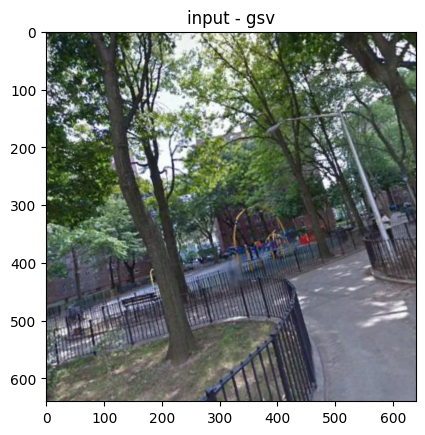

In [37]:
path = '/home/yjlee/Desktop/PerspectiveFields/datasets/gsv/google_street_view_191210/manhattan/0b3f2342_3ae593c2/gsvi_76_12_14_409.jpg'
img = read_image(path, format="BGR")
plt.imshow(img[:,:,::-1])
plt.title("input - gsv")
plt.savefig('gsv image')
plt.show()

## Inference perspective fields

In [38]:
pred = demo_perspective.run_on_image(img)

## Visualize predictions

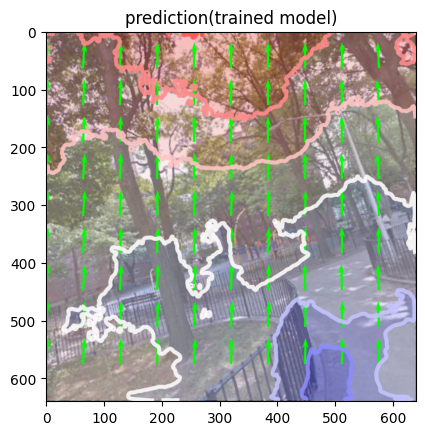

In [39]:
pred_vis = draw_perspective_fields(
    img[:,:,::-1], 
    pred['pred_gravity_original'].cpu().detach(), 
    np.radians(pred['pred_latitude_original'].cpu().detach()),
    color=(0,1,0) 
)
plt.imshow(pred_vis)
plt.title("prediction(trained model)")
plt.savefig('gsv image_trained model')
plt.show()